In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image

from sktime.datasets import make_causal_pricing

## Data

### Loading the dataset

In [2]:
# We use the default parameters to load the dataset
n_series = 4467
n_timepoints = 100
n_categories_d = 45
n_categories_k = 15
random_state = 43

np.random.seed(random_state)

X, y, ground_truth = make_causal_pricing(
    n_series=n_series,
    n_timepoints=n_timepoints,
    n_categories_d=n_categories_d,
    n_categories_k=n_categories_k,
    random_state=random_state,
    return_ground_truth=True,
)

print("Shapes:", X.shape, y.shape)

Shapes: (446700, 7) (446700, 1)


In [3]:
X.head()

discount        stock  week_number   d   k  promotion  \
article_id time                                                          
0          0          0.0  2947.622282            0  34  14          0   
           1          0.0  2945.926912            1  34  14          0   
           2          0.0  2929.237180            2  34  14          0   
           3          0.0  2908.204290            3  34  14          0   
           4          0.1  2882.443930            4  34  14          0   

                        p0  
article_id time             
0          0     28.748704  
           1     28.748704  
           2     28.748704  
           3     28.748704  
           4     28.748704

In [4]:
y.head()

demand
article_id time           
0          0      1.695370
           1     16.689732
           2     21.032890
           3     25.760360
           4     45.219542

### Exploring Ground Truth

In [5]:
ground_truth.keys()

dict_keys(['treatment_effects', 'base_demand', 'causal_dag', 'metadata'])

In [6]:
ground_truth["treatment_effects"].head()

article_id
0   -3.765241
1   -2.699831
2   -5.162729
3   -1.445816
4   -2.317666
Name: treatment_effect, dtype: float64

In [7]:
ground_truth["base_demand"].head()

base_demand
article_id time             
0          0      109.941163
           1      124.935524
           2      129.278682
           3      134.006152
           4      142.640755

In [8]:
ground_truth["metadata"]

{'n_series': 4467,
 'n_timepoints': 100,
 'n_categories_d': 45,
 'n_categories_k': 15,
 'reference': 'Schultz et al. (2024), arXiv:2312.15282',
 'random_state': 43,
 'causal_structure': 'q_it = q^b_it + p_it * e_i',
 'treatment_variable': 'price',
 'outcome_variable': 'demand',
 'heterogeneous_effects': True}

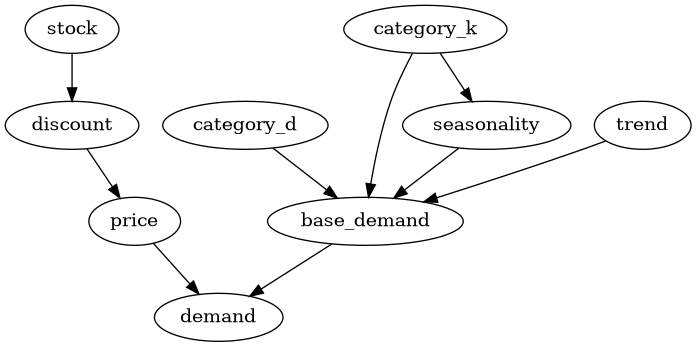

In [9]:
G = ground_truth["causal_dag"]

viz = G.to_graphviz()
viz.draw("causal_forecasting.png", prog="dot")
Image("causal_forecasting.png")

## Exploratory Data Analysis

### 1. Quick Sanity Checks
Check ranges, missing values, and distribution shapes.


Describing X
            discount          stock    week_number              d  \
count  446700.000000  446700.000000  446700.000000  446700.000000   
mean        0.219011    3413.470503      49.500000      21.581375   
std         0.199758    3605.290710      28.866102      13.522900   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000     491.735590      24.750000      10.000000   
50%         0.200000    2198.329109      49.500000      22.000000   
75%         0.400000    5324.278663      74.250000      33.000000   
max         0.500000   22644.438023      99.000000      44.000000   

                   k      promotion             p0  
count  446700.000000  446700.000000  446700.000000  
mean        7.005597       0.294829      34.565253  
std         4.346454       0.455966      26.023151  
min         0.000000       0.000000       0.032610  
25%         3.000000       0.000000      14.762836  
50%         7.000000       0.000000      29.523

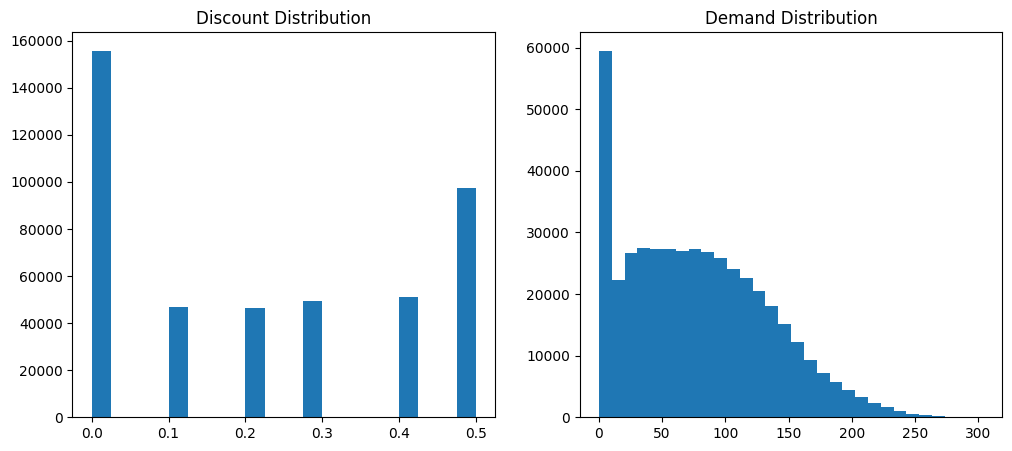

In [10]:
print("Describing X")
print(X.describe())
print("\nDescribing y")
print(y.describe())

# Histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(X["discount"], bins=20)
plt.title("Discount Distribution")

plt.subplot(1, 2, 2)
plt.hist(y["demand"], bins=30)
plt.title("Demand Distribution")
plt.show()

### 2. Select 5 Random Articles (Fixed for whole notebook)

In [11]:
unique_ids = X.index.get_level_values("article_id").unique()
sample_ids = np.random.choice(unique_ids, size=5, replace=False)
sample_ids

array([ 424, 3616, 3548, 2246, 2076])

### 3. Demand Over Time for Selected Articles

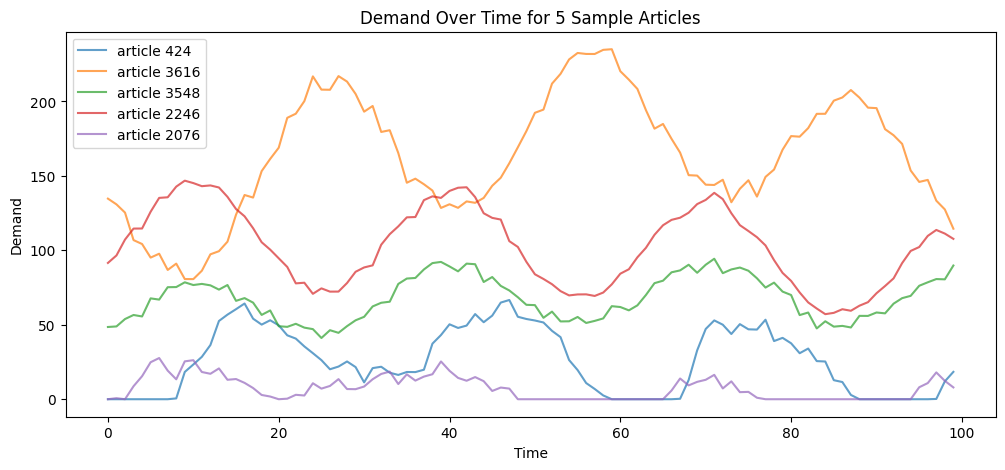

In [12]:
plt.figure(figsize=(12, 5))
for i in sample_ids:
    series = y.loc[i]["demand"]
    plt.plot(series.index, series.values, label=f"article {i}", alpha=0.7)

plt.title("Demand Over Time for 5 Sample Articles")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend()
plt.show()

### 4. Stock / Discount / Demand Evolution for a Single Article
This helps visualize the pricing policy reacting to stock.


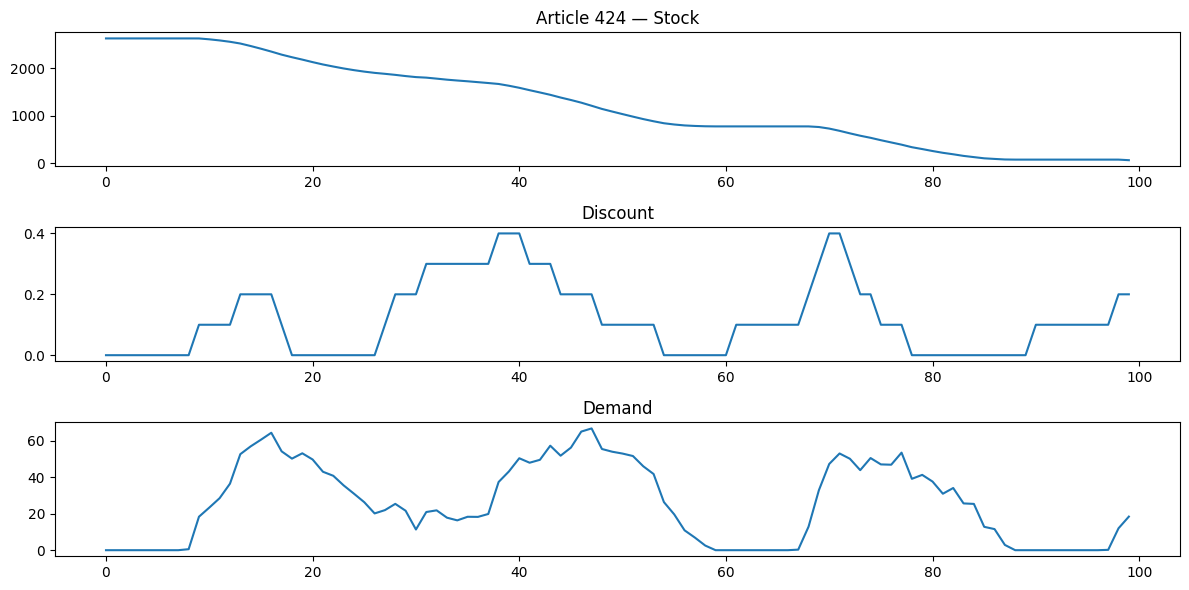

In [13]:
chosen = sample_ids[0]
sub = X.loc[chosen].join(y.loc[chosen])

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(sub.index, sub["stock"])
plt.title(f"Article {chosen} — Stock")

plt.subplot(3, 1, 2)
plt.plot(sub.index, sub["discount"])
plt.title("Discount")

plt.subplot(3, 1, 3)
plt.plot(sub.index, sub["demand"])
plt.title("Demand")
plt.tight_layout()
plt.show()

### 5. Discount → Demand Relationship
For articles pooled (dense, but confirms negative slope).

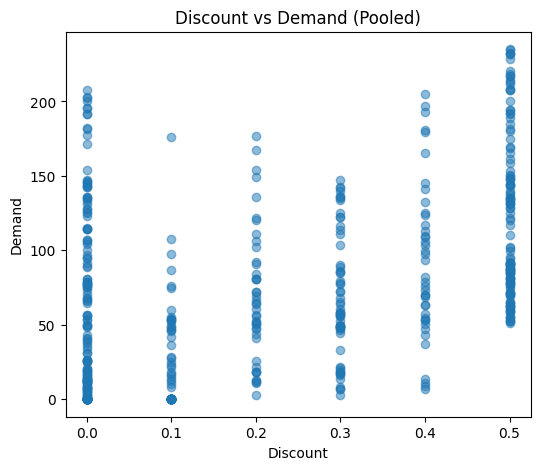

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(X.loc[sample_ids]["discount"], y["demand"].loc[sample_ids], alpha=0.5)
plt.xlabel("Discount")
plt.ylabel("Demand")
plt.title("Discount vs Demand (Pooled)")
plt.show()

### 6. Category Effects on Demand (Brand `d` and Group `k`)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


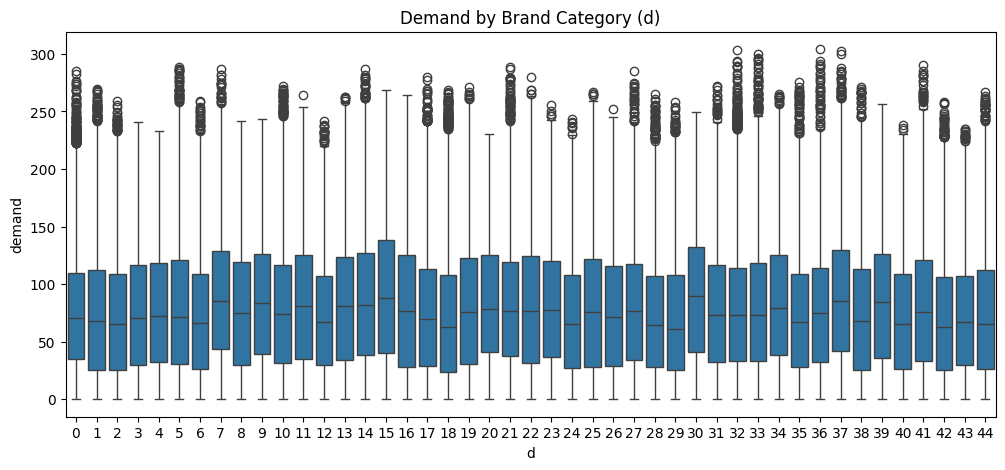

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


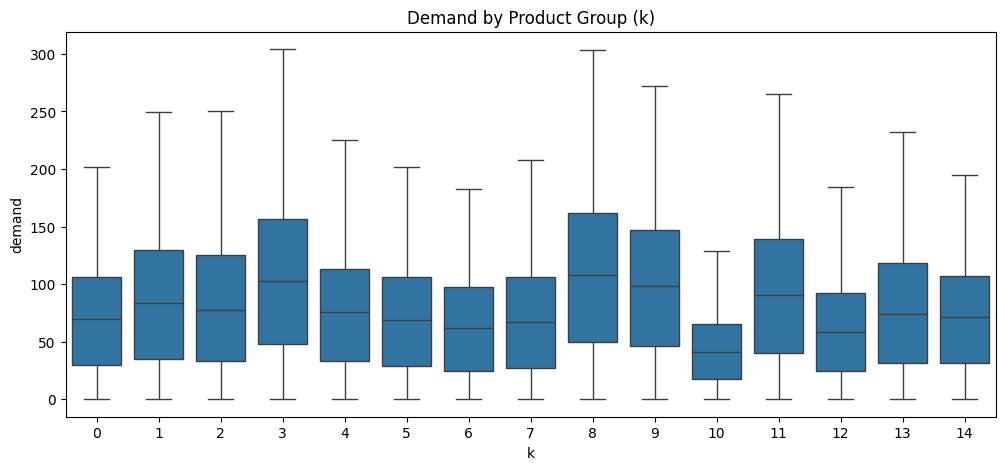

In [15]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=X["d"], y=y["demand"])
plt.title("Demand by Brand Category (d)")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x=X["k"], y=y["demand"])
plt.title("Demand by Product Group (k)")
plt.show()

### 7. Seasonality Check - Average Demand by Week Number


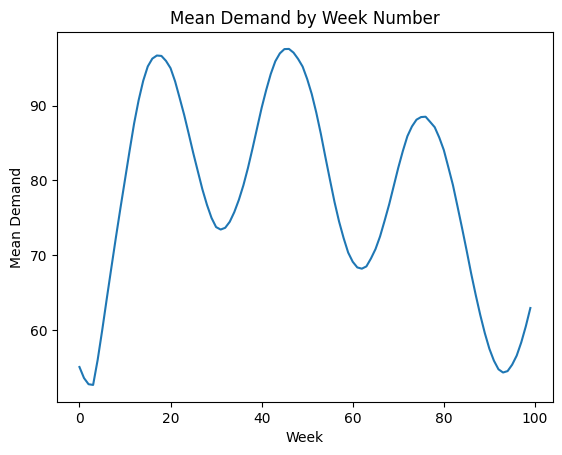

In [16]:
mean_by_week = y["demand"].groupby(X["week_number"]).mean()
plt.plot(mean_by_week.index, mean_by_week.values)
plt.title("Mean Demand by Week Number")
plt.xlabel("Week")
plt.ylabel("Mean Demand")
plt.show()